===== 情绪-成交量组合 vs BTC涨跌幅 统计 =====
              涨跌幅均值(%)  涨跌幅中位数(%)  涨跌幅标准差(%)   样本数
情绪-成交量组合                                          
低情绪（恐惧）_nan       0.20       0.20        NaN     1
低情绪（恐惧）_低成交量     -0.03      -0.01       3.49  1603
低情绪（恐惧）_高成交量      1.09       0.92       6.44    29
高情绪（贪婪)_低成交量      0.31       0.10       3.13  1243
高情绪（贪婪)_高成交量      1.16       1.40       4.39     9


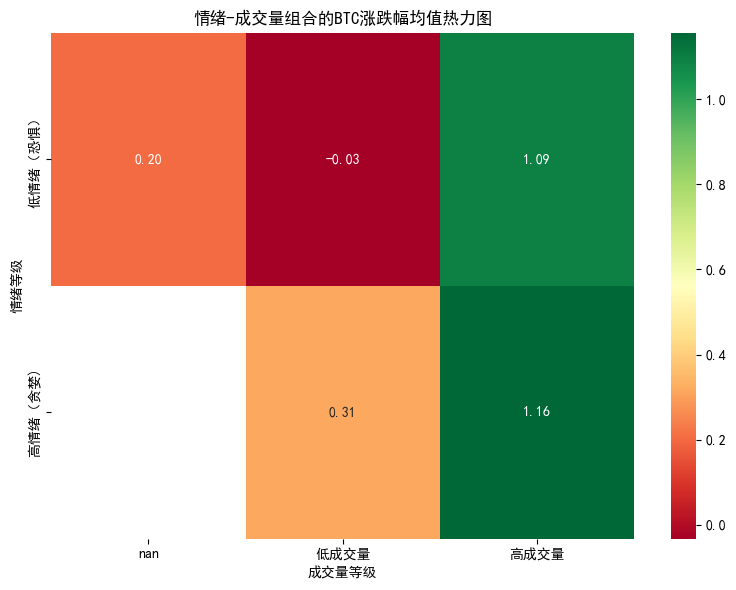

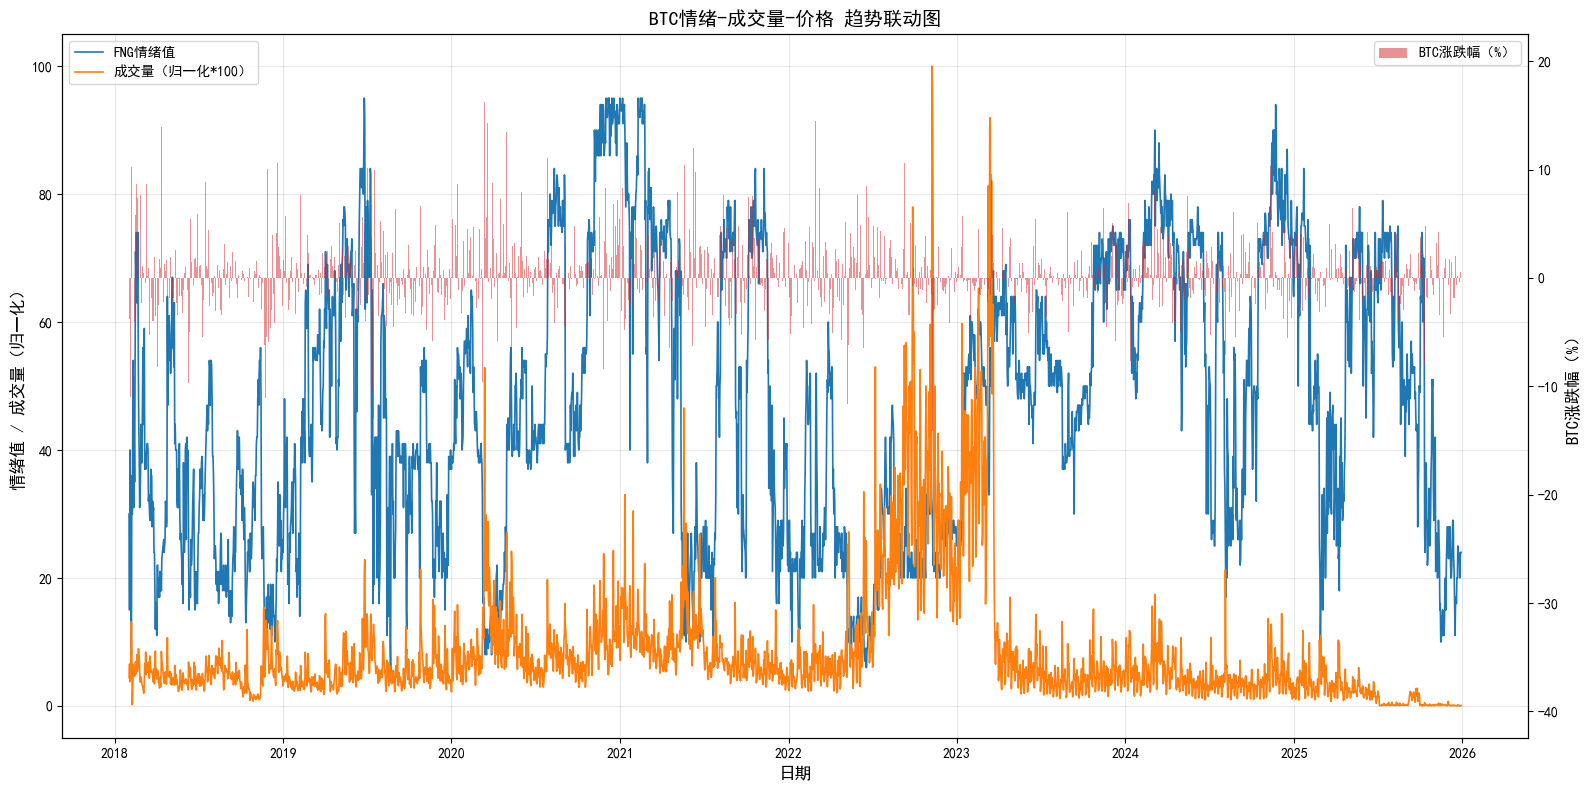

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ========== 1. 读取现有清洗数据 ==========
result_dir = r"C:\Users\33759\Desktop\自选动作 陈正扬 2326010229\结果数据"
data_path = r"C:\Users\33759\Desktop\自选动作 陈正扬 2326010229\修改后数据\BTC_FNG_清洗后数据.xlsx"

if not os.path.exists(result_dir):
    os.makedirs(result_dir)

df = pd.read_excel(data_path)
df['日期'] = pd.to_datetime(df['日期'])
df = df.sort_values('日期').reset_index(drop=True)

# ========== 2. 特征工程：修复分类类型拼接问题 ==========
df['成交量_归一化'] = (df['成交量'] - df['成交量'].min()) / (df['成交量'].max() - df['成交量'].min())

# 划分情绪等级（转换为字符串类型，避免分类类型）
df['情绪等级'] = pd.cut(
    df['情绪值'],
    bins=[0,50,100],
    labels=['低情绪（恐惧）', '高情绪（贪婪)']
).astype(str)  # 关键：将分类类型转为字符串

# 划分成交量等级（转换为字符串类型）
df['成交量等级'] = pd.cut(
    df['成交量_归一化'],
    bins=[0,0.5,1],
    labels=['低成交量', '高成交量']
).astype(str)  # 关键：将分类类型转为字符串

# 生成组合标签（现在是字符串+字符串拼接）
df['情绪-成交量组合'] = df['情绪等级'] + '_' + df['成交量等级']

# ========== 3. 三维联动统计：不同组合下的价格涨跌幅 ==========
combo_stats = df.groupby('情绪-成交量组合')['涨跌幅（百分比）'].agg([
    'mean', 'median', 'std', 'count'
]).round(2)
combo_stats.columns = ['涨跌幅均值(%)', '涨跌幅中位数(%)', '涨跌幅标准差(%)', '样本数']

print("===== 情绪-成交量组合 vs BTC涨跌幅 统计 =====")
print(combo_stats)
combo_stats.to_excel(os.path.join(result_dir, "三维联动_情绪成交量涨跌幅统计.xlsx"), engine='openpyxl')

# ========== 4. 可视化：热力图 + 趋势联动图 ==========
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 4.1 热力图：情绪等级 vs 成交量等级 → 涨跌幅均值
pivot_data = df.pivot_table(
    index='情绪等级',
    columns='成交量等级',
    values='涨跌幅（百分比）',
    aggfunc='mean'
)
fig1, ax1 = plt.subplots(figsize=(8, 6))
sns.heatmap(pivot_data, annot=True, cmap='RdYlGn', fmt='.2f', ax=ax1)
ax1.set_title('情绪-成交量组合的BTC涨跌幅均值热力图', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, "三维联动_热力图.png"), dpi=300, bbox_inches='tight')
plt.show()

# 4.2 趋势联动图：情绪值 + 成交量（归一化） + 价格涨跌幅
fig2, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(df['日期'], df['情绪值'], color='#1f77b4', linewidth=1.2, label='FNG情绪值')
ax1.plot(df['日期'], df['成交量_归一化']*100, color='#ff7f0e', linewidth=1.2, label='成交量（归一化*100）')
ax1.set_xlabel('日期', fontsize=12)
ax1.set_ylabel('情绪值 / 成交量（归一化）', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.bar(df['日期'], df['涨跌幅（百分比）'], color='#d62728', alpha=0.5, label='BTC涨跌幅（%）')
ax2.set_ylabel('BTC涨跌幅（%）', fontsize=12)
ax2.legend(loc='upper right')

plt.title('BTC情绪-成交量-价格 趋势联动图', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, "三维联动_趋势图.png"), dpi=300, bbox_inches='tight')
plt.show()